# Imports

In [56]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import numpy as np
import os

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Initialize Dataset

In [57]:
#####################
# Reading Data Paths
#####################
train_df = pd.read_csv("/kaggle/input/bean-leaf-lesions-classification/train.csv")
val_df = pd.read_csv("/kaggle/input/bean-leaf-lesions-classification/val.csv")

data_df = pd.concat([train_df, val_df], ignore_index=True)

data_df["image:FILE"] = "/kaggle/input/bean-leaf-lesions-classification/" + data_df["image:FILE"]

print("Data shape is: ", data_df.shape)
print()
data_df.head()

Data shape is:  (1167, 2)



,image:FILE,category
0,/kaggle/input/bean-leaf-lesions-classification...,0
1,/kaggle/input/bean-leaf-lesions-classification...,0
2,/kaggle/input/bean-leaf-lesions-classification...,0
3,/kaggle/input/bean-leaf-lesions-classification...,0
4,/kaggle/input/bean-leaf-lesions-classification...,0


In [58]:
print("Classes are: ")
print(data_df["category"].unique())
print()
print("Classes ditrubution are: ")
print(data_df["category"].value_counts())

Classes are: 
[0 1 2]

Classes ditrubution are: 
category
2    393
1    389
0    385
Name: count, dtype: int64


# Data Split

In [59]:
train = data_df.sample(frac=0.7, random_state=42)
test = data_df.drop(train.index)

# Preprocessing Objects

In [60]:
label_encoder = LabelEncoder()

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Custom Dataset Class

In [61]:
class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
     self.dataframe = dataframe
     self.transform = transform
     self.labels = torch.tensor(label_encoder.fit_transform(dataframe['category']))

  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    img_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]
    image = Image.open(img_path).convert('RGB')
    if self.transform:
      image = self.transform(image)

    return image, label

In [62]:
#########################
# Create Dataset Objects
#########################
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

# Visualize Images

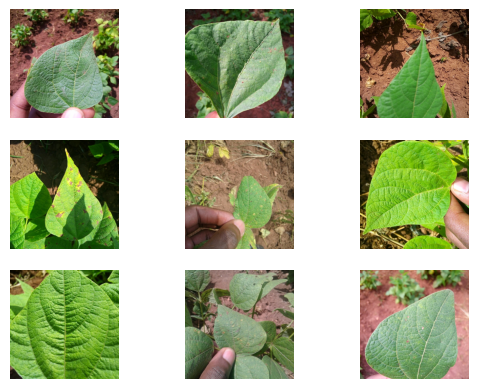

In [63]:
n_rows = 3
n_cols = 3
f, axarr = plt.subplots(n_rows, n_cols)
for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n = 1)['image:FILE'].iloc[0]).convert('RGB')
    axarr[row, col].imshow(image)
    axarr[row, col].axis('off')

plt.show()

# Hyperparameters

In [64]:
LR = 1e-3
BATCH_SIZE = 4
EPOCHS = 15

# DataLoaders

In [65]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Pre-trained Model

In [66]:
googlenet_model = models.googlenet(weights='DEFAULT')
for param in googlenet_model.parameters():
  param.requires_grad = True

In [67]:
googlenet_model.fc

Linear(in_features=1024, out_features=1000, bias=True)

In [68]:
num_classes = len(data_df["category"].unique())
googlenet_model.fc = torch.nn.Linear(googlenet_model.fc.in_features, num_classes)
googlenet_model.to(device)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [69]:
#####################################
# Define loss function and optimizer
#####################################
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss
optimizer = Adam(googlenet_model.parameters(), lr=LR) # Adam optimizer

# Training

In [70]:
total_loss_train_plot = []
total_acc_train_plot = []

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0

  for (inputs, labels) in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    outputs = googlenet_model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()
    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    total_acc_train += train_acc
    optimizer.step()

  total_loss_train_plot.append(round(total_loss_train/1000, 4))
  total_acc_train_plot.append(round(total_acc_train/(train_dataset.__len__())*100, 4))
  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {round(total_loss_train/100, 4)} Train Accuracy {round((total_acc_train)/train_dataset.__len__() * 100, 4)}%')
  print()

Epoch 1/15, Train Loss: 1.725 Train Accuracy 64.3819%

Epoch 2/15, Train Loss: 1.3366 Train Accuracy 74.1738%

Epoch 3/15, Train Loss: 1.0889 Train Accuracy 81.3953%

Epoch 4/15, Train Loss: 0.9998 Train Accuracy 82.9865%

Epoch 5/15, Train Loss: 0.9572 Train Accuracy 83.3537%

Epoch 6/15, Train Loss: 0.7067 Train Accuracy 88.2497%

Epoch 7/15, Train Loss: 0.6969 Train Accuracy 88.0049%

Epoch 8/15, Train Loss: 0.6058 Train Accuracy 89.7185%

Epoch 9/15, Train Loss: 0.485 Train Accuracy 93.3905%

Epoch 10/15, Train Loss: 0.5726 Train Accuracy 90.0857%

Epoch 11/15, Train Loss: 0.3971 Train Accuracy 94.492%

Epoch 12/15, Train Loss: 0.6815 Train Accuracy 88.0049%

Epoch 13/15, Train Loss: 0.3241 Train Accuracy 95.9608%

Epoch 14/15, Train Loss: 0.491 Train Accuracy 91.9217%

Epoch 15/15, Train Loss: 0.2895 Train Accuracy 96.2056%



# Testing

In [71]:
with torch.no_grad():
    total_loss_test = 0
    total_acc_test = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        prediction = googlenet_model(inputs)

        test_loss = criterion(prediction, labels)
        total_loss_test += test_loss.item()

        test_acc = (torch.argmax(prediction, axis=1) == labels).sum().item()
        total_acc_test += test_acc

print(f"Accuracy: {round(total_acc_test / len(test_dataset) * 100, 2)}%")
print(f"Avg loss: {round(total_loss_test / len(test_loader), 4)}")


Accuracy: 92.29%
Avg loss: 0.2199


# Plotting Training Progress

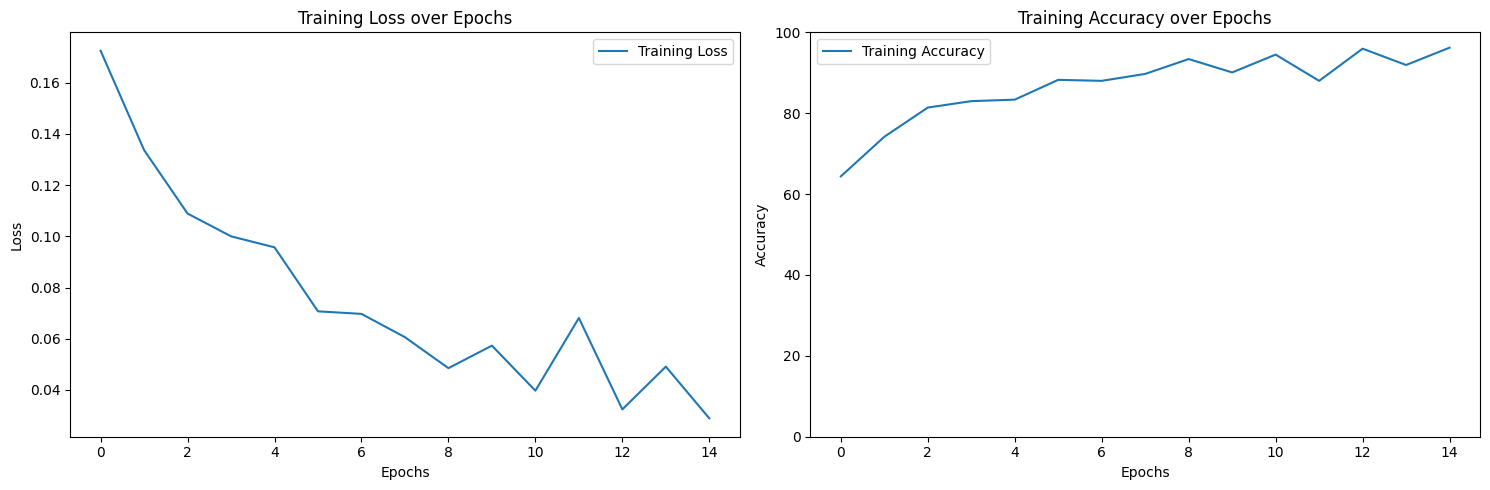

In [72]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].set_title('Training Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].set_ylim([0, 2])
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].set_title('Training Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].set_ylim([0, 100])
axs[1].legend()

plt.tight_layout()

plt.show()